In [1]:
import crispifier
from pathlib import Path
import shutil
from sqlalchemy import create_engine, select
from sqlalchemy.orm import Session
from orm import Input, MipMap, Model, Output, PaletteUse, Palette, Preference

In [2]:
import pathlib

In [3]:
search = pathlib.Path("../resources/")

In [4]:
list(search.glob("*.u"))

[PosixPath('../resources/DeusExDeco.u'),
 PosixPath('../resources/DeusExItems.u'),
 PosixPath('../resources/DeusExCharacters.u')]

In [4]:
import sqlite3
import csv
DB_NAME = "textures.db"

with sqlite3.connect(DB_NAME) as conn:
    cursor = conn.cursor()
    model_hash, = cursor.execute(
        """SELECT 
            model_hash 
        FROM 
            models 
        WHERE 
            model_name = '4x_DigitalFrames_2.1_Aggressive.pth'"""
    ).fetchone()

In [5]:
engine = create_engine("sqlite:///" + DB_NAME, echo=True, future=True)
with Session(engine) as session:
    stmt = select(Preference) 
    pref = session.execute(stmt).first()
    out = pref[0].output

2022-06-23 07:58:12,759 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-06-23 07:58:12,766 INFO sqlalchemy.engine.Engine SELECT preferences.image_hash, preferences.model_hash 
FROM preferences
2022-06-23 07:58:12,767 INFO sqlalchemy.engine.Engine [generated in 0.00119s] ()
2022-06-23 07:58:12,828 INFO sqlalchemy.engine.Engine SELECT outputs.model_hash AS outputs_model_hash, outputs.image_hash AS outputs_image_hash, outputs.output_data AS outputs_output_data 
FROM outputs 
WHERE outputs.model_hash = ? AND outputs.image_hash = ?
2022-06-23 07:58:12,829 INFO sqlalchemy.engine.Engine [generated in 0.00091s] ('f9d9eb7698287573c3c4c08116d1ee75c5c68edf7b905ce8e8d3e1bea0b243d2', 'bc826e60bc12936a824e0828768a87490afa165f0c8fa4f3b89570dfdd340f44')
2022-06-23 07:58:12,837 INFO sqlalchemy.engine.Engine ROLLBACK


In [6]:
root = Path("/home/jason/.wine/drive_c/deusex/")
paths = [
    (path, path.parent.parent / "Textures" / path.name)
    for path in root.glob("Textures.bak/*.utx")
    if path.name
    not in {
        "DXFonts.utx",
        "Effects.utx",
        "Extras.utx",
        "InfoPortraits.utx",
        "CoreTexDetail.utx",
        "Render.utx",
        "Palettes.utx",
        "CoreTexWater.utx",
    }
] 

In [6]:

for path, output_path in paths:
#     if path.name != "NYCBar.utx":
#         continue
    with open(path, "rb") as f:
        package = crispifier.package.parse(f.read())
        break
#         crispifier.rescale_package_db(
#             package, 4, DB_NAME, model_hash=None, blur=2, grow=1, shrink=1, threshold=128
#         )
#     with open(output_path, "wb") as f:
#         f.write(crispifier.package.build(package))
#     print(path.name)

In [12]:
for obj, header in zip(package.export_objects, package.export_headers):
    if obj.cls_name == "Texture":
        if obj.obj_name.startswith("FlatFXTex"):
            local_factor = 1
        else:
            local_factor = 4
        try:
            upscaled = get_upscaled_texture_db(
                package,
                obj,
                4,
                DB_NAME,
                model_hash=None,
            )
            print("Upscaling!")
            break
        except ImageNotFoundException:
            
            print("Failed")
            break

Upscaling!


In [8]:
engine = create_engine("sqlite:///" + DB_NAME, future=True)
from crispifier import (
    ImageNotFoundException, get_upscaled_texture_db, 
    get_palette, get_image_array, get_image, palettize, hash_image,
    get_upscaled_from_orm,
)
from wand.image import Image
import numpy as np

In [43]:
with Session(engine) as session:
    for path, output_path in paths:
        with open(path, "rb") as f:
            package = crispifier.package.parse(f.read())
            for obj, header in zip(package.export_objects, package.export_headers):
                if obj.cls_name == "Texture":
                    
                    palette_array = get_palette(obj, package)
                    image_array = get_image_array(obj)
                    image = get_image(image_array, palette_array)
                    image_hash = hash_image(image)
                    upscaled = get_upscaled_from_orm(image, session)
                    outpath = output_path.parent / output_path.stem / obj.group_name /(obj.obj_name + ".dds")
                    outpath.parent.mkdir(parents=True, exist_ok=True)
                    with Image.from_array(np.array(upscaled)) as img:
                        img.compression = "dxt1"
                        img.save( filename=outpath )

In [42]:
outpath = output_path.parent / output_path.stem / obj.group_name /(obj.obj_name + ".dds")
help(outpath.parent.mkdir)

Help on method mkdir in module pathlib:

mkdir(mode=511, parents=False, exist_ok=False) method of pathlib.PosixPath instance
    Create a new directory at this given path.



In [17]:
with Image.from_array(np.array(upscaled)) as img:
    img.compression = "dxt1"
    img.save(filename="test.dds")

In [28]:
obj.obj_name

'AIPrototype_A02'

In [48]:
np.all(np.array(upscaled) == [255, 0, 255], axis=-1).shape

(1024, 512)

In [49]:
np.array(upscaled).shape

(1024, 512, 3)

In [9]:
with Session(engine) as session:
    for path, output_path in paths:
        with open(path, "rb") as f:
            package = crispifier.package.parse(f.read())
            for obj, header in zip(package.export_objects, package.export_headers):
                if obj.cls_name == "Texture":
                    palette_array = get_palette(obj, package)
                    image_array = get_image_array(obj)
                    image = get_image(image_array, palette_array)
                    image_hash = hash_image(image)
                    stmt = select(Input).where(Input.image_hash == image_hash)
                    input_image, = session.execute(stmt).one()
                    input_image.group_name = obj.group_name
    session.commit()

In [11]:
p =  Path("input_image.source_file")
p.stem

'input_image'

In [1]:
from crispifier2 import rescale_all, rescale_single

from sqlalchemy import create_engine
from sqlalchemy.orm import Session
engine = create_engine("sqlite:///textures.db", future=True)
output_dir = "/home/jason/.wine/drive_c/deusex/Textures"

In [17]:
with Session(engine) as session:
    rescale_all(session, 4, output_dir, grow=3, shrink=3, blur=1.5)

In [81]:
from crispifier2 import scale_mask
from orm import Input
from io import BytesIO
import numpy as np
from PIL import Image, ImageTransform, ImageFilter

session = Session(engine)
input_image = session.query(Input).where(Input.image_hash == "bc826e60bc12936a824e0828768a87490afa165f0c8fa4f3b89570dfdd340f44").one()
rescale_single(session, 4, input_image, output_dir, grow=3, shrink=3, blur=1)
image = Image.open(BytesIO(input_image.input_data))

In [112]:
import sys
from crispifier import get_processable
from ESRGAN import architecture as arch
import torch
from wand.image import Image as ImageWand
device = torch.device("cpu") 
def load_model(model_path, device):
    state_dict = torch.load(model_path)
    model = arch.RRDB_Net(
        3, 
        3, 
        32, 
        12, 
        gc=32, 
        upscale=1, 
        norm_type=None, 
        act_type='leakyrelu', 
        mode='CNA', 
        res_scale=1, 
        upsample_mode='upconv'
    )
    model.load_state_dict(state_dict, strict=True)
    del state_dict
    model.eval()
    for k, v in model.named_parameters():
        v.requires_grad = False
    return model.to(device)

def process(img, model):
    img = img * 1. / np.iinfo(img.dtype).max
    img = img[:, :, [2, 1, 0]]
    img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
    img_LR = img.unsqueeze(0)
    img_LR = img_LR.to(device)

    output = model(img_LR).data.squeeze(0).float().cpu().clamp_(0, 1).numpy()
    output = output[[2, 1, 0], :, :]
    output = np.transpose(output, (1, 2, 0))
    output = (output * 255.).round()
    return output


models = [
    load_model("models/1x_NormalMapGenerator-CX-Lite_200000_G.pth", device),
    load_model("models/1x_FrankenMapGenerator-CX-Lite_215000_G.pth", device),
]
image = WandImage(filename="/home/jason/.wine/drive_c/deusex/Textures/CoreTexMetal/Metal/BoilerDetail_D.dds")    
rlts = [process(np.array(image), model) for model in models]

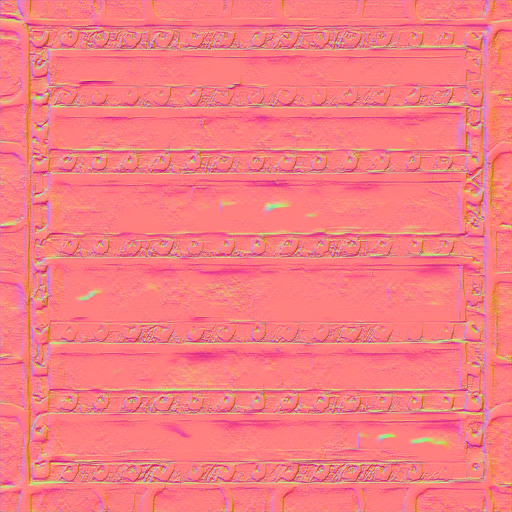

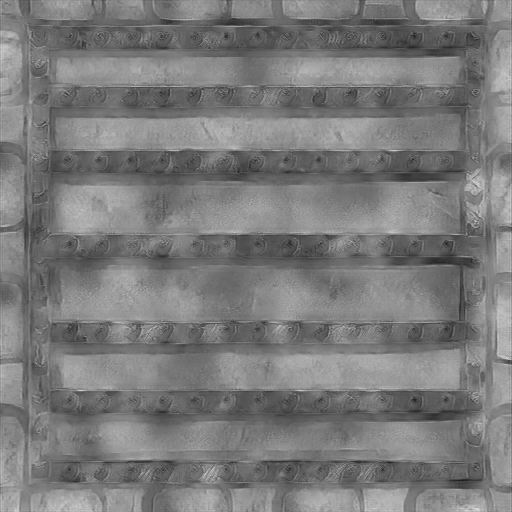

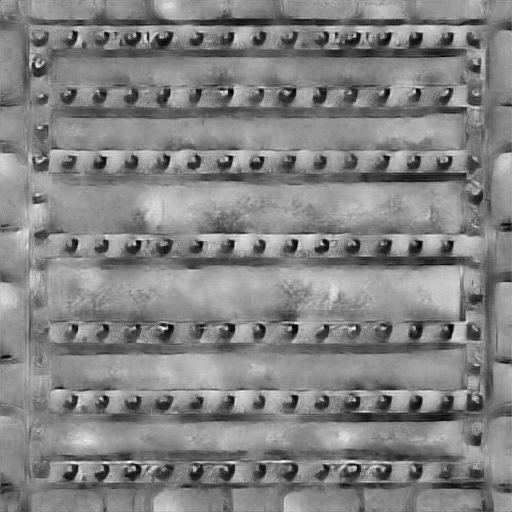

In [115]:
from PIL import Image
from wand.image import Image as WandImage
normal = Image.fromarray(rlts[0].astype(np.uint8))
roughness = Image.fromarray(rlts[1][:, :, 1].astype(np.uint8))
displacement = Image.fromarray(rlts[1][:, :, 0].astype(np.uint8))
display(normal)
display(roughness)
display(displacement)


In [100]:
rlts[1][:, :, 0]

array([[ 57.,  59.,  67., ...,  82.,  97.,  99.],
       [ 46.,  18.,  27., ...,  41.,  53.,  93.],
       [ 46.,  13.,  23., ...,  26.,  28.,  71.],
       ...,
       [174., 149., 171., ...,  61.,  34.,  64.],
       [184., 166., 180., ...,  70.,  50.,  67.],
       [150., 161., 165., ...,  78.,  50.,  48.]], dtype=float32)

In [1]:
from bumper import generate_bumps
from sqlalchemy import create_engine
from sqlalchemy.orm import Session

import torch
device = torch.device("cpu")
engine = create_engine("sqlite:///textures.db", future=True)
session = Session(engine)

model_paths = [
    "models/1x_NormalMapGenerator-CX-Lite_200000_G.pth", 
    "models/1x_FrankenMapGenerator-CX-Lite_215000_G.pth", 
]

output_dir = "/home/jason/.wine/drive_c/deusex/Textures"
generate_bumps(session, model_paths, output_dir, device)


In [2]:
from bumper import WandImage

In [3]:
help(WandImage)

Help on class Image in module wand.image:

class Image(BaseImage)
 |  Image(image=None, blob=None, file=None, filename=None, pseudo=None, background=None, colorspace=None, depth=None, extract=None, format=None, height=None, interlace=None, resolution=None, sampling_factors=None, units=None, width=None)
 |  
 |  An image object.
 |  
 |  :param image: makes an exact copy of the ``image``
 |  :type image: :class:`Image`
 |  :param blob: opens an image of the ``blob`` byte array
 |  :type blob: :class:`bytes`
 |  :param file: opens an image of the ``file`` object
 |  :type file: file object
 |  :param filename: opens an image of the ``filename`` string. Additional
 |                   :ref:`read_mods` are supported.
 |  :type filename: :class:`basestring`
 |  :param format: forces filename to  buffer. ``format`` to help
 |                 ImageMagick detect the file format. Used only in
 |                 ``blob`` or ``file`` cases
 |  :type format: :class:`basestring`
 |  :param width: t